In [10]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'Biased Sampling'))

In [11]:
import pandas as pd

from XGB import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer
from stealthy_sampling import *

In [12]:
data = pd.read_csv('../../../Dataset/Fraudulent_online_shops_dataset.csv')
data['Label'] = data['Label'].replace({'fraudulent': 0, 'legitimate': 1})
data['Presence of free contact emails'] = data['Presence of free contact emails'].replace({2: 1, 3: 1})
data['Indication of young domain '] = data['Indication of young domain '].replace({2: 1})
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
protected_feature="Indication of young domain "
data.head()

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


,Label,Domain length,Top domain length,Presence of prefix 'www',Number of digits,Number of letters,Number of dots (.),Number of hyphens (-),Presence of credit card payment,Presence of money back payment,...,Presence of crypto currency,Presence of free contact emails,Presence of logo URL,SSL certificate issuer organization list item,Indication of young domain,Presence of TrustPilot reviews,TrustPilot score,Presence of SiteJabber reviews,Presence in the standard Tranco list,Tranco List rank
0,0,24,3,1,0,27,2,0,1,1,...,0,0,0,9,1,0,NaN,0,0,-1
1,0,18,4,1,0,20,2,1,0,1,...,0,1,0,1,1,0,NaN,0,0,-1
2,1,28,2,1,0,30,2,1,1,0,...,0,1,1,2,1,0,-1.0,0,0,-1
3,1,13,2,0,0,17,1,0,1,0,...,0,1,1,9,1,0,-1.0,0,0,-1
4,0,19,3,1,0,22,2,0,1,1,...,0,0,1,2,1,0,NaN,0,0,-1


In [13]:
x_train, x_test, y_train, y_test, feature_names, scaler = Data_Handler(
        df=data,
        target_column='Label',
        protected_feature=protected_feature,
        do_scaling=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling only continuous numerical features (excluding heuristic categoricals and protected feature by default).
Features actually being scaled: ['Domain length', 'Top domain length']


In [14]:
print(len(x_train.columns))
x_train.head()

12


,Domain length,Top domain length,Number of digits,Number of hyphens (-),Presence of credit card payment,Presence of cash on delivery payment,Presence of crypto currency,Presence of free contact emails,Presence of logo URL,Presence of SiteJabber reviews,Presence in the standard Tranco list,Indication of young domain
665,-0.319739,-1.147256,0,0,1,0,0,1,1,0,0,0
901,-0.763097,0.175736,1,0,1,1,0,1,1,0,0,0
131,0.788654,0.175736,0,0,0,0,0,0,0,0,0,1
252,-0.098061,0.175736,0,1,0,0,0,1,1,0,0,0
330,1.897047,0.175736,0,0,1,1,0,1,0,0,0,0


Accuracy: 0.9064327485380117
Precision: 0.9063919469854519
Recall: 0.9064327485380117
F-1: 0.9063810985113293


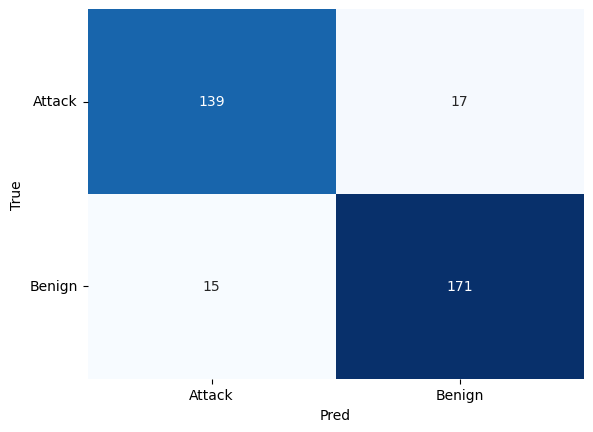

In [15]:
model = base_model_call(x_train, y_train, protected_feature, True)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)

In [16]:
# Pass the DataFrame to the attacker class to maintain feature names for plotting
attacker = AdversarialSHAPBackgroundAttack(
        model=model,
        X_train=x_train,
        sensitive_feature_name=protected_feature,
        sensitive_feature_index=list(x_train.columns).index(protected_feature),
        explainer_type='tree',
        background_size=200,
        lambda_reg=1e-4,
        gamma_entropy=1e-7
    )

Running attack with TreeExplainer...


[22:52:41] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


[Before] Mean SHAP per feature:
[ 0.00545237  0.01453048  0.00210168 -0.00265436  0.01912122  0.03137193
  0.00621175 -0.03461942  0.00384518 -0.00930929  0.          0.01909312]
Weight stats: min=0.003769292830947361, max=0.006341087357665199, mean=0.0050000000000036396


Converting A to a CSC (compressed sparse column) matrix; may take a while.
Converting P to a CSC (compressed sparse column) matrix; may take a while.
[22:52:42] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


[After] Mean SHAP per feature:
[-0.01728016 -0.14217693 -0.00530362 -0.00320295 -0.00036523  0.01397035
 -0.00710663  0.07993559 -0.04024009  0.01712606  0.         -0.27813941]


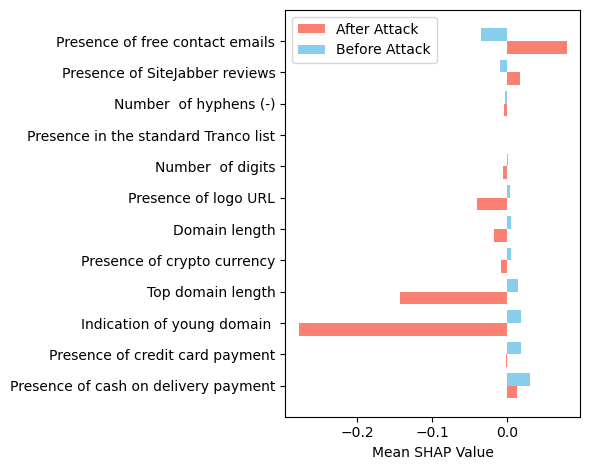

In [17]:
biased_weights, before, after = attacker.run_attack()
attacker.plot_shap_comparison(before, after)

In [18]:
print(f"Sensitive feature '{protected_feature}' importance before attack: {before[attacker.sensitive_feature_index]:.4f}")
print(f"Sensitive feature '{protected_feature}' importance after attack: {after[attacker.sensitive_feature_index]:.4f}")
    
change = after[attacker.sensitive_feature_index] - before[attacker.sensitive_feature_index]
pct_change = (change / before[attacker.sensitive_feature_index] * 100) if before[attacker.sensitive_feature_index] != 0 else float('inf')
print(f"Change in importance: {change:.4f} ({pct_change:.2f}%)")

Sensitive feature 'Indication of young domain ' importance before attack: 0.0191
Sensitive feature 'Indication of young domain ' importance after attack: -0.2781
Change in importance: -0.2972 (-1556.75%)
